# Application 1 BoxCox

The present script describes the application of a multiple linear regression technique using the [statsmodel](https://www.statsmodels.org/) library, as well as the interpretation of its results. The residuals obtained through the created model will not adhere to normality (based on the Shapiro-Francia test) and, therefore, the use of the box-cox transformation will be necessary to normalize the data and apply Regression again.

## Dataset Description

The database provides information on the age and length of a group of babies, with length as the dependent variable and age as the predictor variable. The idea is to predict the length of the babies through a linear regression model that uses only age.

## Implementation

- Check the dataset.


- Descriptive Statistics.


- Adjust the model equation using the least squares method.


- Checking the Residual Normality.


- Box-Cox Transformation.


- Adjust the model again (with the transformed y).


- Compare the results  gotten by the linear models with and without the box-cox transformation.


***

## Checking the Dataset

In [2]:
# Libraries needed
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
from sfrancia import shapiroFrancia
from scipy.stats import boxcox

sns.set()
warnings.filterwarnings("ignore")

In [3]:
# Checking the data
df_babies = pd.read_csv('Data/length_babies.csv', index_col=0)
df_babies.head(5)

,length,age
1,63.07,19.00
2,65.63,21.00
3,65.63,22.50
4,66.73,22.50
5,66.37,23.25


In [4]:
# Checking NaN values
df_babies.isna().sum()

length    0
age       0
dtype: int64

In [5]:
# Checking parameters types
df_babies.dtypes

length    float64
age       float64
dtype: object

## Descriptive Statistics

In [6]:
# Descriptive statistics
df_babies.describe().T.round(2).drop('count',1)

,mean,std,min,25%,50%,75%,max
length,66.92,12.85,31.90,56.47,70.4,75.81,87.63
age,25.31,12.98,2.15,12.50,26.0,33.00,60.00


The verification of outliers using the interquartile range (IQR) is a common statistical method that involves identifying values that significantly deviate from the data distribution.

The IQR is the difference between the third quartile (Q3) and the first quartile (Q1) of a dataset. Values that are below Q1 - 1.5 x IQR or above Q3 + 1.5 x IQR are considered outliers.

In other words, if a data value falls outside this range, it is considered an outlier and may be removed or treated differently depending on the analysis objective.

In [7]:
# Checking the presence of outliers in each column
for column in df_babies.columns:
    q1 = np.percentile(df_babies[column], 25)
    q3 = np.percentile(df_babies[column], 75)
    iqr = q3 - q1
    print(f' {len(df_babies.loc[(df_babies[column] < (q1 - 1.5 * iqr))|(df_babies[column] > (q3 + 1.5 * iqr))])} outliers on "{column}" column.')

 0 outliers on "length" column.
 0 outliers on "age" column.


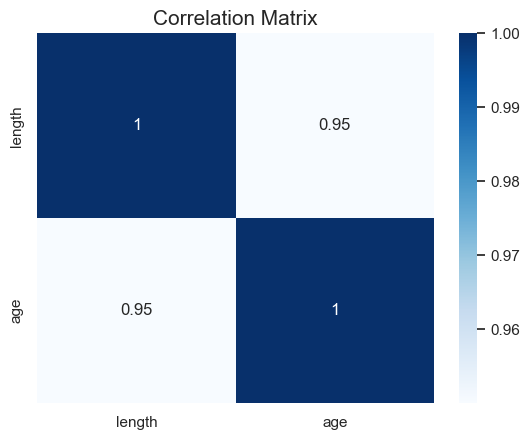

In [8]:
# Checking Correlations
sns.heatmap(df_babies.corr(), annot=True, cmap="Blues")
plt.title('Correlation Matrix', size=15);

We will create a scatter plot to try to demonstrate the behavior of the data.

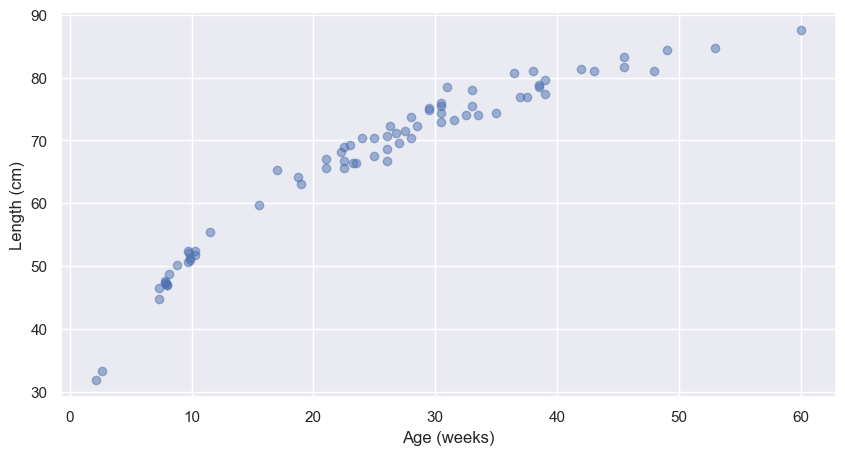

In [9]:
fig = plt.figure(figsize=(10,5))
plt.scatter(df_babies['age'], df_babies['length'], alpha=.5)
plt.xlabel('Age (weeks)')
plt.ylabel('Length (cm)');

## Adjusting the Model

A multiple linear regression model will be created, which considers 'age' as the predictor variables and 'length' as the dependent variable.

In [10]:
# Splitting predictor and dependent variables
X = df_babies['age'].values
y = df_babies['length'].values

In [11]:
# Adding the constant, for considering the intercept
X = sm.add_constant(X)

In [12]:
# Fit the linear regression model using the OLS method
model = sm.OLS(y, X).fit()

In [13]:
# Print the summary statistics of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     667.7
Date:                Tue, 25 Apr 2023   Prob (F-statistic):           3.72e-38
Time:                        09:40:25   Log-Likelihood:                -207.26
No. Observations:                  74   AIC:                             418.5
Df Residuals:                      72   BIC:                             423.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.1004      1.034     41.665      0.0

As we can see, the values corresponding to the intercept and coefficient of 'age' are 43.1, and 0.94, respectively. The p-values of the t-statistics are less than 0.05, therefore, all variables are statistically significant. So, let's see how the predicted values behave in a plot.

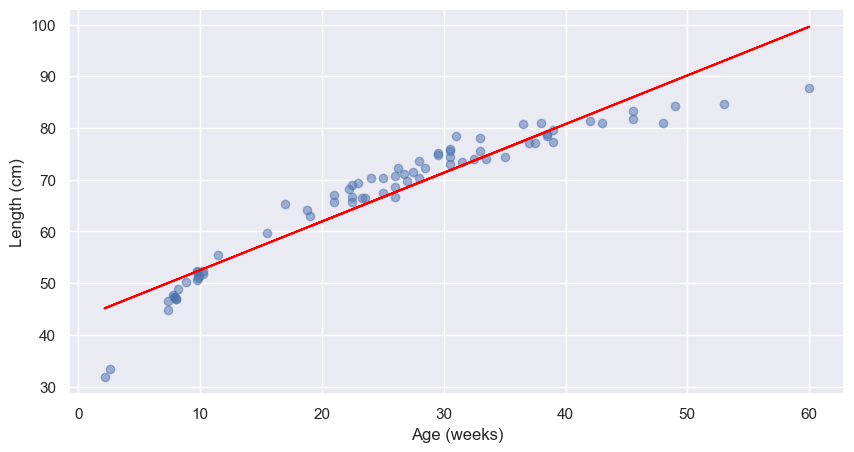

In [14]:
# Getting the predicted values
predicted_values = model.predict(sm.add_constant(X))

# Plotagem do gráfico de dispersão com a reta
fig = plt.figure(figsize=(10,5))
plt.scatter(df_babies['age'].values, y, alpha=.5)
plt.plot(df_babies['age'].values, predicted_values, color='red')
plt.xlabel('Age (weeks)')
plt.ylabel('Length (cm)');

As can be observed, the line does not seem to be well fitted to the data, which may be due to non-normality of the residuals. To check the residual normality, we will use the Shapiro-Francia test, and if the test shows non-normality of the residuals, it will be necessary to apply the Box-Cox transformation to the dependent variable.

## Checking the Residual Normality

An initial way to assess the residual normality of a model is to plot a histogram of the residuals.

In [15]:
# Getting the residuals
residuals = predicted_values - df_babies['length']

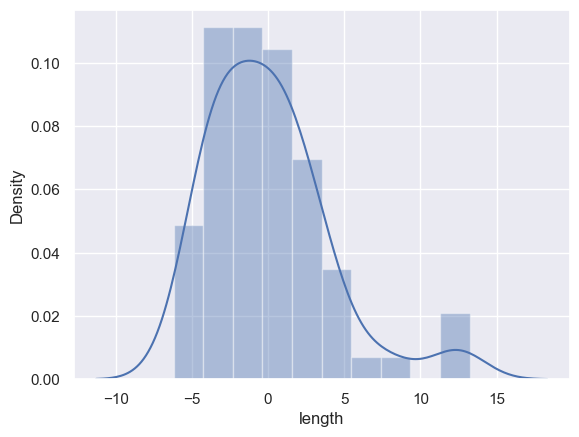

In [16]:
# Plotting the Residuals Histogram
sns.distplot(residuals);

The histogram indicates that most likely the residuals are not adherent to the normal distribution, therefore the Shapiro-Francia test will be applied.

In [17]:
# Applying the shapiro Francia test
shapiroFrancia(residuals)

{'method': 'Shapiro-Francia normality test',
 'statistics W': 0.9087044262594453,
 'statistics z': 3.627650491545392,
 'p-value': 0.00014300603555436982}

As the p-value is less than 0.05, we can conclude that the residuals do not follow a normal distribution.

## Box-Cox Transformation

The Box-Cox transformation is a technique used to transform a non-normal dependent variable into a normally distributed variable. The transformation is a mathematical function that can be applied to a variable with different parameters. The goal is to find the optimal value of the parameter that produces the transformation with the closest possible distribution to a normal distribution. The optimal parameter is found through a grid search or numerical optimization.

We will find, through the scipy library, the boxcox lambda and the already calculated dependent variable values, according to the formula:

$ybc_i = \Large \frac {y^{λ} - 1}{λ} $

In [18]:
# Getting the lambda and the dependent variable transformed
xt, lmbda = boxcox(df_babies['length'])

In [19]:
# Checking
print((((df_babies['length']**lmbda)-1)/lmbda).values[:5])
print(xt[0:5])

[22966.08319266 25529.06530947 25529.06530947 26682.72235641
 26301.65766765]
[22966.08319266 25529.06530947 25529.06530947 26682.72235641
 26301.65766765]


The boxcox function is returning the values of the predictor variable correctly, therefore, these transformed values will be applied in a new model in place of the predictor variable.

## Adjusting the Model

A multiple linear regression model will be created, considering 'length' (with the boxcox transformation) as the dependent variable.

In [20]:
# Splitting predictor and dependent variables
X_bc = df_babies['age'].values
y_bc = xt

In [21]:
# Adding the constant, for considering the intercept
X_bc = sm.add_constant(X_bc)

In [22]:
# Fit the linear regression model using the OLS method
model_bc = sm.OLS(y_bc, X_bc).fit()

In [23]:
# Print the summary statistics of the model
print(model_bc.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     1822.
Date:                Tue, 25 Apr 2023   Prob (F-statistic):           7.16e-53
Time:                        09:40:26   Log-Likelihood:                -681.77
No. Observations:                  74   AIC:                             1368.
Df Residuals:                      72   BIC:                             1372.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4995.1602    630.253      7.926      0.0

As it can be observed, in the new model the predictor variables are significant again, and the R2 is 0.962, higher than the initially obtained value of 0.903.

In [24]:
# Getting the predicted values
predicted_values_bc = model_bc.predict(sm.add_constant(X))

In [25]:
# Getting the residuals
residuals_bc = predicted_values_bc - xt

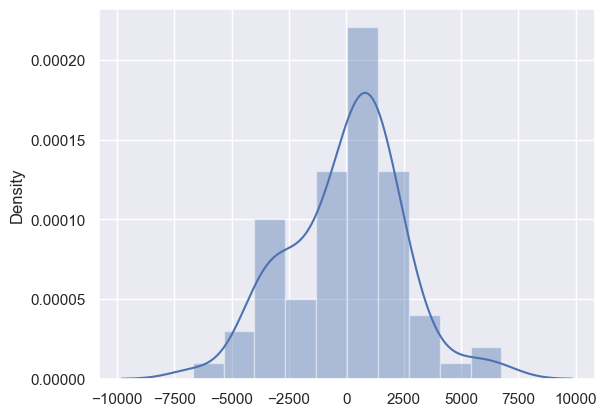

In [26]:
# Plotting the Residuals Histogram
sns.distplot(residuals_bc);

In [27]:
# Applying the shapiro Francia test
shapiroFrancia(residuals_bc)

{'method': 'Shapiro-Francia normality test',
 'statistics W': 0.9729952103345909,
 'statistics z': 1.2666151749155228,
 'p-value': 0.1026464618655531}

Now the residuals follow a distribution adherent to normality, according th the Shapiro-Francia normality test. The fitted values of y should be compared with those obtained before the transformation.

## Comparison

A DataFrame will be created, containing the dependent variable real values, and the values gotten by the linear models with and without the box-cox transformation.

In [28]:
# DataFrame
df_y = df_babies['length'].to_frame()
df_y['predicted_linear_without_bc'] = predicted_values
df_y['predicted_linear_with_bc'] = (((predicted_values_bc * lmbda) + 1)) ** (1 / lmbda)
df_y.head(10)

,length,predicted_linear_without_bc,predicted_linear_with_bc
1,63.07,60.981260,63.097300
2,65.63,62.863455,65.004303
3,65.63,64.275102,66.375858
4,66.73,64.275102,66.375858
5,66.37,64.980925,67.044337
6,66.37,65.216200,67.264723
7,67.47,66.627847,68.562586
8,70.40,66.627847,68.562586
9,68.57,67.568944,69.405676
10,71.13,68.274768,70.027015


Also, a comparison of the scatter plots will be performed. Below we have the scatter plot of the points with the adjusted values according to linear regression (without the boxcox transformation) in red, and in blue we have the line adjusted with the help of the transformation.

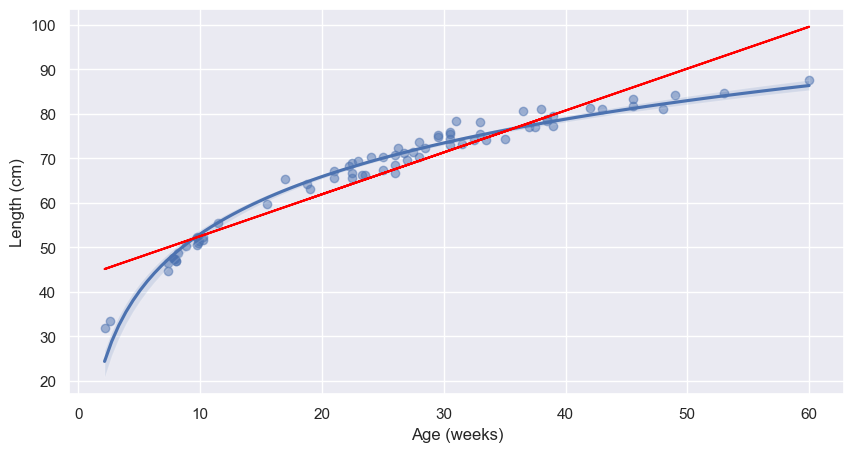

In [29]:
# Plotting the Scatters
fig = plt.figure(figsize=(10,5))
sns.regplot(x="age", y="length", data=df_babies,
             logx=True, scatter_kws={'alpha':0.5})
plt.plot(df_babies['age'], model.fittedvalues, color='red')
plt.xlabel('Age (weeks)')
plt.ylabel('Length (cm)');

## Conclusions

The normality of the residuals obtained through the application of a linear regression model is of vital importance. It has been demonstrated, in this simple dataset with only one predictor variable, that the linear model for certain distributions can have statistically significant variables, a considerable R² value, and yet not correspond to the ideal fit for that set of data.

The application of the boxcox transformation on the dependent variable for model creation significantly improved the fit of the data to the model. This could be verified both by the model evaluation metrics (R²) and by the data plotting.